In [2]:
#!/usr/bin/env python
# -*- coding: utf8 -*-
import sys
from xml.etree import ElementTree
from xml.etree.ElementTree import Element, SubElement
from lxml import etree
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
XML_EXT = '.xml'
ENCODE_METHOD = 'utf-8'

NOTE_DIR = os.path.dirname(os.path.realpath('__file__'))
BASE_DIR = os.path.join(NOTE_DIR, '..')
DOC_DIR = os.path.join(BASE_DIR, 'doc')
LIB_DIR = os.path.join(BASE_DIR, 'lib')

VOC_DIR = os.path.join(DOC_DIR, 'converter\kitti_voc\kittivoc_trainval\Annotations')
OUTPUT_DIR = os.path.join(DOC_DIR, 'converter\output' )

VOC_DIR_NEW = os.path.join(DOC_DIR, 'converter_new\kitti_voc_ori\kittivoc_trainval\Annotations')
OUTPUT_DIR_NEW = os.path.join(DOC_DIR, 'converter_new\output' )






In [3]:

# 1.VOC的xml读取部分
# 2.产生长宽比部分
# 3.进行kmeans计算部分


class PascalVocReader:
    """
    this class will be used to get transfered width and height from voc xml files
    """
    def __init__(self, filepath, width, height, object_name):
        # shapes type:
        # [labbel, [(x1,y1), (x2,y2), (x3,y3), (x4,y4)], color, color, difficult]
        self.shapes = []
        self.filepath = filepath
        self.verified = False
        self.width=width
        self.height=height
        self.object_name = [object_name]

        try:
            self.parseXML()
        except:
            pass

    def getShapes(self):
        return self.shapes

    def addShape(self, bndbox, width,height):
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        width_trans = (xmax - xmin)/width*self.width
        height_trans = (ymax-ymin)/height *self.height
        #width_trans = xmax - xmin
        #height_trans = ymax - ymin
        
        points = [width_trans,height_trans]
        self.shapes.append((points))

# Voc读取Car部分
    def parseXML(self):
        assert self.filepath.endswith(XML_EXT), "Unsupport file format"
        parser = etree.XMLParser(encoding=ENCODE_METHOD)
        xmltree = ElementTree.parse(self.filepath, parser=parser).getroot()
        pic_size = xmltree.find('size')
        size = (int(pic_size.find('width').text),int(pic_size.find('height').text))
        if self.object_name[0] == "All" :
            self.object_name = ["Cyclist", "Car", "Pedestrian"]
#         print("object_name:{}".format(self.object_name))
        for object_iter in xmltree.findall('object'):         
            if object_iter.find('name').text in self.object_name:
                bndbox = object_iter.find("bndbox")
                self.addShape(bndbox, *size)
        return True


class create_w_h_txt:
    def __init__(self,vocxml_path, txt_dir, img_size, object_name='All'):
        self.voc_path = vocxml_path
        self.txt_dir = txt_dir
        self.object_name = object_name
        self.width = img_size[0]
        self.height = img_size[1]
        name_ = str(self.object_name) + "_" + str(self.width) + "_" + str(self.height) + ".txt"
        self.file_name = os.path.join(self.txt_dir, name_)
        self.process_file()
        
    def _gether_w_h(self):
        pass
    def _write_to_txt(self):
        pass
    def process_file(self):
        
#         file_w = open(self.txt_path,'a')
#         name_ = str(self.object_name) + "_" + str(self.width) + "_" + str(self.height) + ".txt"
#         file_name = os.path.join(self.txt_dir, name_)
#        print("file_name:{}".format(self.file_name))
        file_w = open(self.file_name, 'w')
    # print (self.txt_path)
        for file in os.listdir(self.voc_path):
            file_path = os.path.join(self.voc_path, file)
            
            #xml_parse = PascalVocReader(file_path,304,304)
            #xml_parse = PascalVocReader(file_path, 1000, 450, self.object_name)
            #xml_parse = PascalVocReader(file_path, 300, 300)
            xml_parse = PascalVocReader(file_path, self.width, self.height, self.object_name)
            data = xml_parse.getShapes()
            for w,h in data :
                txtstr = str(w)+' '+str(h)+'\n'
                #print (txtstr)
                file_w.write(txtstr)
        file_w.close()

# k_means聚类
class kMean_parse:
    def __init__(self,path_txt):
        self.path = path_txt
        self.km = KMeans(n_clusters=5,init="k-means++",n_init=10,max_iter=3000000,tol=1e-3,random_state=0)
        self._load_data()

    def _load_data (self):
        self.data = np.loadtxt(self.path)

    def parse_data (self):
        self.y_k = self.km.fit_predict(self.data)
        for i in range(5):
            ratio = self.km.cluster_centers_[i][0]/self.km.cluster_centers_[i][1]
            print('{}宽高:{}'.format(i,self.km.cluster_centers_[i]))
            print('ratio:\n',ratio)
        print(self.km.cluster_centers_)


    def plot_data (self):
        plt.scatter(self.data[self.y_k == 0, 0], self.data[self.y_k == 0, 1], s=50, c="orange", marker="o", label="cluster 1")
        plt.scatter(self.data[self.y_k == 1, 0], self.data[self.y_k == 1, 1], s=50, c="green", marker="s", label="cluster 2")
        plt.scatter(self.data[self.y_k == 2, 0], self.data[self.y_k == 2, 1], s=50, c="blue", marker="^", label="cluster 3")
        plt.scatter(self.data[self.y_k == 3, 0], self.data[self.y_k == 3, 1], s=50, c="gray", marker="*",label="cluster 4")
        plt.scatter(self.data[self.y_k == 4, 0], self.data[self.y_k == 4, 1], s=50, c="yellow", marker="d",label="cluster 5")
       # draw the centers
        plt.scatter(self.km.cluster_centers_[:, 0], self.km.cluster_centers_[:, 1], s=250, marker="*", c="red", label="cluster center")
        name_ = os.path.basename(self.path)[:-4]
        plt.title(name_)
        plt.legend()
        plt.grid()
        
        fig_name_ =  name_+ "_kmeans.pdf"
        fig_path_ = os.path.join(os.path.dirname(self.path), fig_name_)
#         fig_path_ = os.path.join(os.path.dirname(self.pa),fig_name_)
        plt.savefig(fig_path_)
        plt.show()



0宽高:[11.10846755 55.65142071]
ratio:
 0.19960797783305959
1宽高:[ 49.66044959 183.98719128]
ratio:
 0.2699125370963225
2宽高:[ 5.69808297 28.92035385]
ratio:
 0.19702673760134923
3宽高:[19.5738346  90.01580007]
ratio:
 0.21744887657356327
4宽高:[ 33.68008437 140.44705678]
ratio:
 0.23980626684160047
[[ 11.10846755  55.65142071]
 [ 49.66044959 183.98719128]
 [  5.69808297  28.92035385]
 [ 19.5738346   90.01580007]
 [ 33.68008437 140.44705678]]


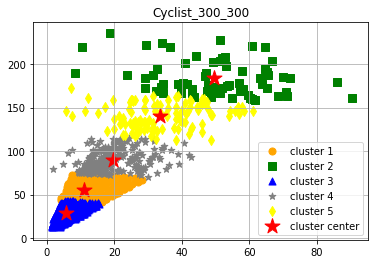

0宽高:[18.95845129 94.97842468]
ratio:
 0.19960797783305947
1宽高:[ 84.75383397 314.00480645]
ratio:
 0.2699125370963225
2宽高:[ 9.72472827 49.3574039 ]
ratio:
 0.19702673760134976
3宽高:[ 33.40601105 153.62696545]
ratio:
 0.21744887657356327
4宽高:[ 57.48067733 239.69631023]
ratio:
 0.23980626684160042
[[ 18.95845129  94.97842468]
 [ 84.75383397 314.00480645]
 [  9.72472827  49.3574039 ]
 [ 33.40601105 153.62696545]
 [ 57.48067733 239.69631023]]


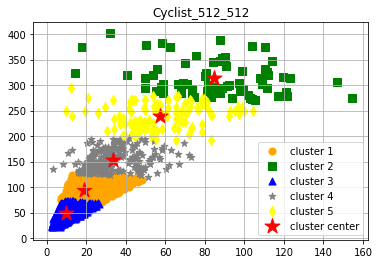

0宽高:[ 66.84856995 132.55324098]
ratio:
 0.5043148659180393
1宽高:[ 98.73845785 213.07305487]
ratio:
 0.4634018971251655
2宽高:[18.1636544  43.21214567]
ratio:
 0.4203367853848951
3宽高:[177.13193457 261.57271282]
ratio:
 0.6771804775198283
4宽高:[35.96845592 82.8288411 ]
ratio:
 0.4342503824033602
[[ 66.84856995 132.55324098]
 [ 98.73845785 213.07305487]
 [ 18.1636544   43.21214567]
 [177.13193457 261.57271282]
 [ 35.96845592  82.8288411 ]]


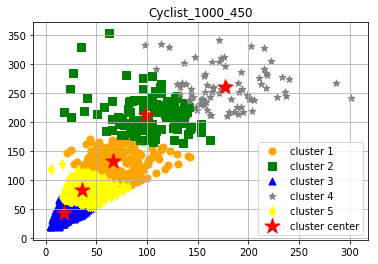

0宽高:[26.40074249 50.09203386]
ratio:
 0.5270447305956746
1宽高:[ 68.84594862 144.63166036]
ratio:
 0.47600883827060947
2宽高:[46.57568679 89.04807472]
ratio:
 0.5230397955288592
3宽高:[11.99412944 25.00432688]
ratio:
 0.4796821564693487
4宽高:[ 80.32948768 264.90202096]
ratio:
 0.3032422606268155
[[ 26.40074249  50.09203386]
 [ 68.84594862 144.63166036]
 [ 46.57568679  89.04807472]
 [ 11.99412944  25.00432688]
 [ 80.32948768 264.90202096]]


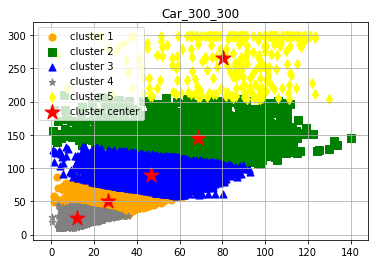

0宽高:[45.05726718 85.49040445]
ratio:
 0.5270447305956754
1宽高:[117.49708565 246.83803367]
ratio:
 0.47600883827060475
2宽高:[ 79.48917213 151.97538085]
ratio:
 0.5230397955288557
3宽高:[20.46998091 42.6740512 ]
ratio:
 0.47968215646931267
4宽高:[137.09565898 452.09944911]
ratio:
 0.3032422606268156
[[ 45.05726718  85.49040445]
 [117.49708565 246.83803367]
 [ 79.48917213 151.97538085]
 [ 20.46998091  42.6740512 ]
 [137.09565898 452.09944911]]


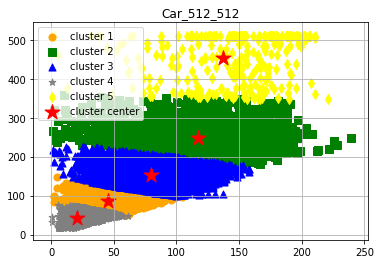

0宽高:[38.43851211 39.31882283]
ratio:
 0.9776109593344761
1宽高:[258.94913574 211.79527774]
ratio:
 1.2226388543653617
2宽高:[155.61639809 145.38739165]
ratio:
 1.0703569018263692
3宽高:[269.85174408 396.26940977]
ratio:
 0.6809805082807394
4宽高:[90.34478532 76.43417949]
ratio:
 1.1819945725492027
[[ 38.43851211  39.31882283]
 [258.94913574 211.79527774]
 [155.61639809 145.38739165]
 [269.85174408 396.26940977]
 [ 90.34478532  76.43417949]]


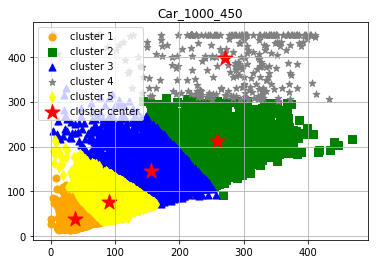

0宽高:[ 18.15289155 132.61423308]
ratio:
 0.13688494162343895
1宽高:[ 7.45346544 61.92361447]
ratio:
 0.12036547778742862
2宽高:[12.59579708 94.56710987]
ratio:
 0.13319426915169144
3宽高:[ 4.14127253 35.70718336]
ratio:
 0.11597869500154304
4宽高:[ 27.21404288 177.75301368]
ratio:
 0.15310031777977506
[[ 18.15289155 132.61423308]
 [  7.45346544  61.92361447]
 [ 12.59579708  94.56710987]
 [  4.14127253  35.70718336]
 [ 27.21404288 177.75301368]]


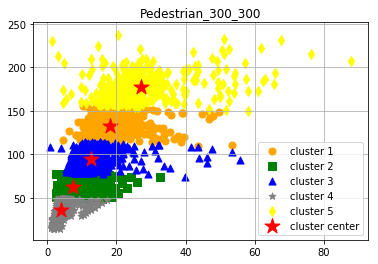

0宽高:[ 30.98093492 226.32829113]
ratio:
 0.136884941623439
1宽高:[ 12.72058102 105.6829687 ]
ratio:
 0.12036547778742855
2宽高:[ 21.49682702 161.39453417]
ratio:
 0.13319426915169139
3宽高:[ 7.06777178 60.9402596 ]
ratio:
 0.11597869500154212
4宽高:[ 46.44529985 303.36514335]
ratio:
 0.15310031777977517
[[ 30.98093492 226.32829113]
 [ 12.72058102 105.6829687 ]
 [ 21.49682702 161.39453417]
 [  7.06777178  60.9402596 ]
 [ 46.44529985 303.36514335]]


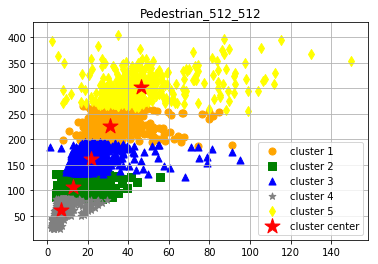

0宽高:[ 94.81833845 266.31772221]
ratio:
 0.3560346553829388
1宽高:[24.20325407 91.05576092]
ratio:
 0.26580694979136243
2宽高:[ 60.25953378 197.79551937]
ratio:
 0.3046557069250208
3宽高:[ 39.44924093 138.75615746]
ratio:
 0.2843062365892936
4宽高:[13.35917917 52.97866621]
ratio:
 0.25216148551717343
[[ 94.81833845 266.31772221]
 [ 24.20325407  91.05576092]
 [ 60.25953378 197.79551937]
 [ 39.44924093 138.75615746]
 [ 13.35917917  52.97866621]]


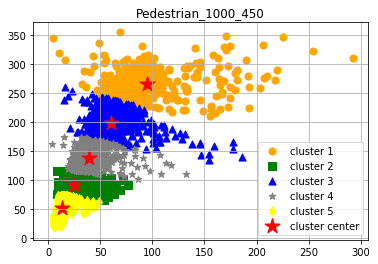

0宽高:[24.30663925 54.39135409]
ratio:
 0.44688424581925557
1宽高:[38.64306549 97.19368568]
ratio:
 0.39758823033935003
2宽高:[ 77.66060514 260.95871459]
ratio:
 0.2975972857074834
3宽高:[ 61.0142692  148.91448728]
ratio:
 0.4097268862969257
4宽高:[11.72703261 26.38255377]
ratio:
 0.44449952449920954
[[ 24.30663925  54.39135409]
 [ 38.64306549  97.19368568]
 [ 77.66060514 260.95871459]
 [ 61.0142692  148.91448728]
 [ 11.72703261  26.38255377]]


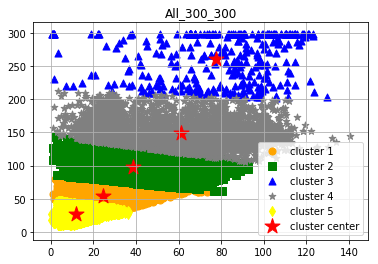

0宽高:[41.48333099 92.82791098]
ratio:
 0.44688424581925607
1宽高:[ 65.95083177 165.87722356]
ratio:
 0.3975882303393502
2宽高:[132.54076611 445.36953957]
ratio:
 0.29759728570748406
3宽高:[104.13101943 254.14739162]
ratio:
 0.40972688629692666
4宽高:[20.01413565 45.02622511]
ratio:
 0.4444995244991922
[[ 41.48333099  92.82791098]
 [ 65.95083177 165.87722356]
 [132.54076611 445.36953957]
 [104.13101943 254.14739162]
 [ 20.01413565  45.02622511]]


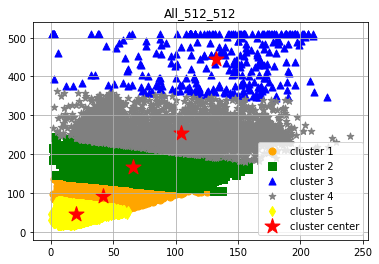

0宽高:[ 75.75172044 206.20548222]
ratio:
 0.36736036124771
1宽高:[263.77621414 238.53666477]
ratio:
 1.1058099365830418
2宽高:[83.68238018 80.11578248]
ratio:
 1.0445180411763808
3宽高:[169.81836121 134.58632656]
ratio:
 1.2617801938140256
4宽高:[34.6959351  42.97062321]
ratio:
 0.8074338353571893
[[ 75.75172044 206.20548222]
 [263.77621414 238.53666477]
 [ 83.68238018  80.11578248]
 [169.81836121 134.58632656]
 [ 34.6959351   42.97062321]]


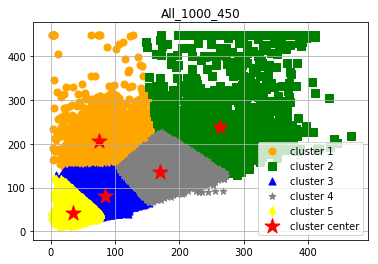

finished


In [4]:
def main():
    voc_dir = VOC_DIR
    output_dir = OUTPUT_DIR
    objects = ["Cyclist", "Car", "Pedestrian", "All"]
#     objects = ["All"]
    img_sizes = [(300, 300), (512, 512), (1000, 450)]
    for ob in objects:
        for si in img_sizes:
            whtxt = create_w_h_txt(voc_dir, output_dir, si, ob)
            kmeans_parse = kMean_parse(whtxt.file_name)
#             print("file_name {}".format(whtxt.file_name))
            kmeans_parse.parse_data()
            kmeans_parse.plot_data()

if __name__ == '__main__':
    main()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    print("finished")

0宽高:[11.05282038 56.35612693]
ratio:
 0.19612455620807268
1宽高:[ 33.5418132  141.21761371]
ratio:
 0.23751862333193613
2宽高:[ 5.77708399 29.29748827]
ratio:
 0.19718700581893586
3宽高:[ 50.93009898 183.04662427]
ratio:
 0.2782356636311114
4宽高:[20.16643677 90.99155797]
ratio:
 0.22162975574135638
[[ 11.05282038  56.35612693]
 [ 33.5418132  141.21761371]
 [  5.77708399  29.29748827]
 [ 50.93009898 183.04662427]
 [ 20.16643677  90.99155797]]


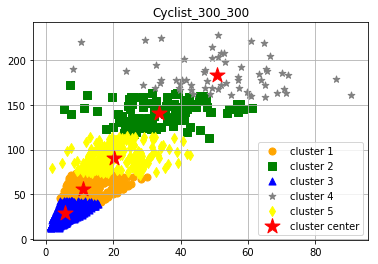

0宽高:[18.86348012 96.18112329]
ratio:
 0.19612455620807287
1宽高:[ 57.24469452 241.01139406]
ratio:
 0.23751862333193607
2宽高:[ 9.85955668 50.00104665]
ratio:
 0.1971870058189361
3宽高:[ 86.92070226 312.39957209]
ratio:
 0.27823566363111146
4宽高:[ 34.41738541 155.29225893]
ratio:
 0.2216297557413564
[[ 18.86348012  96.18112329]
 [ 57.24469452 241.01139406]
 [  9.85955668  50.00104665]
 [ 86.92070226 312.39957209]
 [ 34.41738541 155.29225893]]


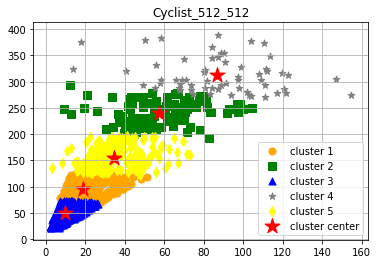

0宽高:[18.24778443 43.43395004]
ratio:
 0.4201272140790824
1宽高:[ 98.54788896 210.94334617]
ratio:
 0.4671770442092985
2宽高:[35.50196833 83.33180475]
ratio:
 0.42603143468079246
3宽高:[ 68.23542459 133.24772974]
ratio:
 0.5120944628634836
4宽高:[178.13405921 261.18019825]
ratio:
 0.682035086926172
[[ 18.24778443  43.43395004]
 [ 98.54788896 210.94334617]
 [ 35.50196833  83.33180475]
 [ 68.23542459 133.24772974]
 [178.13405921 261.18019825]]


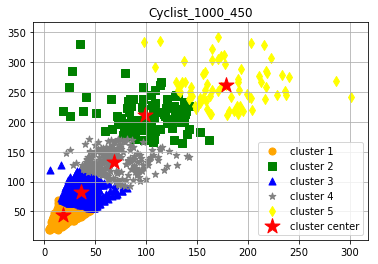

0宽高:[11.2012702  23.06734946]
ratio:
 0.4855898254969658
1宽高:[ 50.83602383 118.50658212]
ratio:
 0.428972154317343
2宽高:[41.84538113 73.75611753]
ratio:
 0.5673479370718448
3宽高:[23.3544811  43.70457839]
ratio:
 0.5343714997876046
4宽高:[ 78.77618279 150.52237313]
ratio:
 0.5233519852009707
[[ 11.2012702   23.06734946]
 [ 50.83602383 118.50658212]
 [ 41.84538113  73.75611753]
 [ 23.3544811   43.70457839]
 [ 78.77618279 150.52237313]]


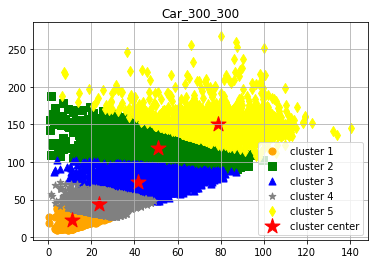

0宽高:[19.11683447 39.36827641]
ratio:
 0.48558982549699986
1宽高:[ 86.76014734 202.25123349]
ratio:
 0.4289721543173417
2宽高:[ 71.41611713 125.87710726]
ratio:
 0.5673479370718443
3宽高:[39.85831441 74.58914712]
ratio:
 0.5343714997876072
4宽高:[134.4446853 256.8915168]
ratio:
 0.5233519852009743
[[ 19.11683447  39.36827641]
 [ 86.76014734 202.25123349]
 [ 71.41611713 125.87710726]
 [ 39.85831441  74.58914712]
 [134.4446853  256.8915168 ]]


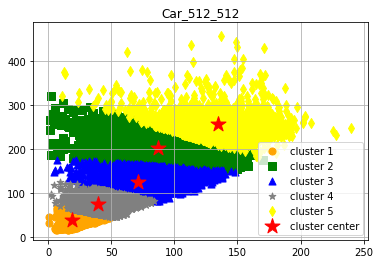

0宽高:[37.11680341 37.18656567]
ratio:
 0.998123992888978
1宽高:[279.58985032 212.30962885]
ratio:
 1.3168967033344028
2宽高:[149.62006584 112.18499912]
ratio:
 1.3336904846019588
3宽高:[169.21587233 196.27237209]
ratio:
 0.8621482001071886
4宽高:[82.90808866 70.43589452]
ratio:
 1.1770715659005266
[[ 37.11680341  37.18656567]
 [279.58985032 212.30962885]
 [149.62006584 112.18499912]
 [169.21587233 196.27237209]
 [ 82.90808866  70.43589452]]


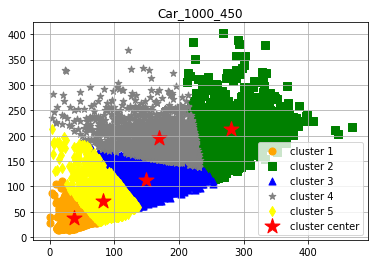

0宽高:[ 7.00082635 61.36426466]
ratio:
 0.11408637235819254
1宽高:[11.26253474 93.05439004]
ratio:
 0.12103173994704751
2宽高:[ 17.40261217 131.84538365]
ratio:
 0.1319925786745689
3宽高:[ 27.03114771 177.4737263 ]
ratio:
 0.15231070127480986
4宽高:[ 3.91608443 35.36448465]
ratio:
 0.11073494981689185
[[  7.00082635  61.36426466]
 [ 11.26253474  93.05439004]
 [ 17.40261217 131.84538365]
 [ 27.03114771 177.4737263 ]
 [  3.91608443  35.36448465]]


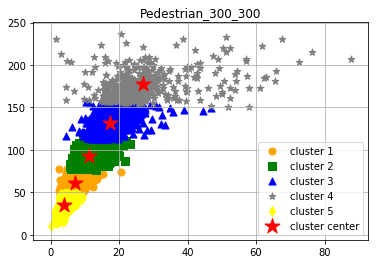

0宽高:[ 11.94807697 104.72834502]
ratio:
 0.11408637235819234
1宽高:[ 19.22139262 158.81282566]
ratio:
 0.12103173994704756
2宽高:[ 29.70045811 225.01612144]
ratio:
 0.13199257867456918
3宽高:[ 46.13315876 302.88849289]
ratio:
 0.15231070127480995
4宽高:[ 6.68345077 60.35538713]
ratio:
 0.11073494981689123
[[ 11.94807697 104.72834502]
 [ 19.22139262 158.81282566]
 [ 29.70045811 225.01612144]
 [ 46.13315876 302.88849289]
 [  6.68345077  60.35538713]]


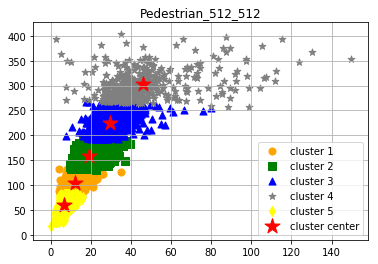

0宽高:[12.7981811  52.23920721]
ratio:
 0.24499187075711648
1宽高:[ 37.29240823 139.16687596]
ratio:
 0.26796899746245606
2宽高:[ 95.65301048 268.76291002]
ratio:
 0.3559010820132787
3宽高:[22.82019191 90.66815037]
ratio:
 0.251689174362146
4宽高:[ 57.65932292 200.29810435]
ratio:
 0.2878675417809936
[[ 12.7981811   52.23920721]
 [ 37.29240823 139.16687596]
 [ 95.65301048 268.76291002]
 [ 22.82019191  90.66815037]
 [ 57.65932292 200.29810435]]


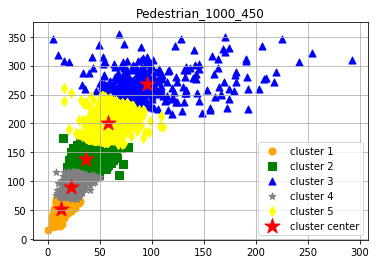

0宽高:[11.36720645 25.13828294]
ratio:
 0.45218706793015756
1宽高:[ 75.89286945 143.56404462]
ratio:
 0.528634238813935
2宽高:[ 25.12534359 144.02991511]
ratio:
 0.17444531278231834
3宽高:[39.9093666  86.68320123]
ratio:
 0.46040485394232644
4宽高:[22.09630295 50.81825292]
ratio:
 0.4348103620620414
[[ 11.36720645  25.13828294]
 [ 75.89286945 143.56404462]
 [ 25.12534359 144.02991511]
 [ 39.9093666   86.68320123]
 [ 22.09630295  50.81825292]]


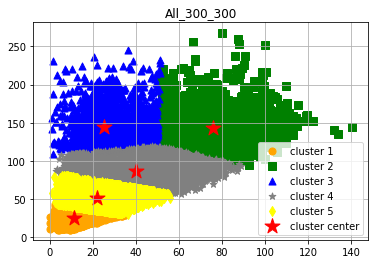

0宽高:[19.40003235 42.90266955]
ratio:
 0.4521870679301461
1宽高:[129.52383053 245.01596949]
ratio:
 0.5286342388139386
2宽高:[ 42.8805864  245.81105513]
ratio:
 0.17444531278231848
3宽高:[ 68.11198567 147.9393301 ]
ratio:
 0.46040485394232433
4宽高:[37.71102371 86.72981832]
ratio:
 0.4348103620620394
[[ 19.40003235  42.90266955]
 [129.52383053 245.01596949]
 [ 42.8805864  245.81105513]
 [ 68.11198567 147.9393301 ]
 [ 37.71102371  86.72981832]]


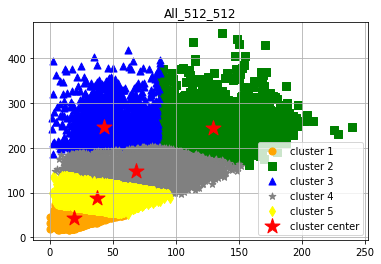

0宽高:[84.33020369 76.64741306]
ratio:
 1.1002354851240814
1宽高:[257.74847862 214.95919517]
ratio:
 1.199057702167017
2宽高:[163.52562786 130.16669319]
ratio:
 1.2562785751802248
3宽高:[ 70.42416849 199.71268047]
ratio:
 0.3526274261953299
4宽高:[34.15164462 43.10456886]
ratio:
 0.7922975572719958
[[ 84.33020369  76.64741306]
 [257.74847862 214.95919517]
 [163.52562786 130.16669319]
 [ 70.42416849 199.71268047]
 [ 34.15164462  43.10456886]]


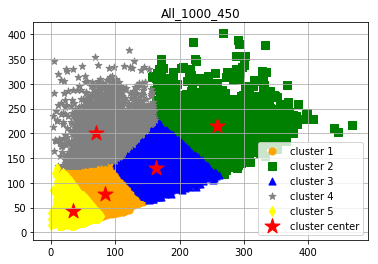

finished


In [5]:
def main():
    voc_dir = VOC_DIR_NEW
    output_dir = OUTPUT_DIR_NEW
    objects = ["Cyclist", "Car", "Pedestrian", "All"]
#     objects = ["All"]
    img_sizes = [(300, 300), (512, 512), (1000, 450)]
    for ob in objects:
        for si in img_sizes:
            whtxt = create_w_h_txt(voc_dir, output_dir, si, ob)
            kmeans_parse = kMean_parse(whtxt.file_name)
#             print("file_name {}".format(whtxt.file_name))
            kmeans_parse.parse_data()
            kmeans_parse.plot_data()

if __name__ == '__main__':
    main()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    print("finished")